In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# 设置输出图片的大小
imsize = 512 if torch.cuda.is_available() else 128  # 仅在 GPU 可用时使用更大尺寸

# 定义图像转换的加载器
loader = transforms.Compose([
    transforms.Resize(imsize),  # 缩放最小边至 imsize，非 imsize x imsize
    transforms.ToTensor()  # 转换为 Tensor
])

# 定义图像加载函数，将图像加载并转换为符合神经网络输入的张量格式
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)  # 增加 batch 维度（单张图像）
    return image.to(device, torch.float)

# 加载风格图和内容图
style_img = image_loader(r"C:\Users\chenl\Desktop\我的深度學習自學\Anime Style Transfer\anime-style-transfer\train\style\00000.png")
content_img = image_loader(r"C:\Users\chenl\Desktop\我的深度學習自學\Anime Style Transfer\anime-style-transfer\train\real\00000.png")

# 检查风格图和内容图的尺寸是否一致
assert style_img.size() == content_img.size(), "内容图和风格图的大小必须一致"


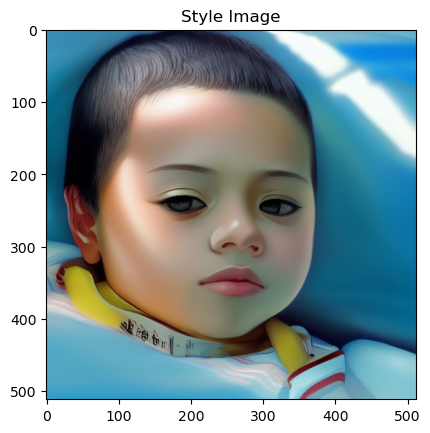

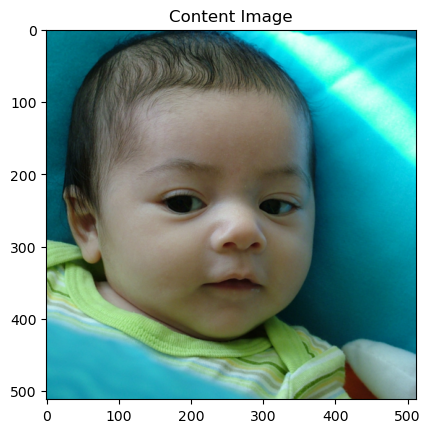

In [4]:
# 定义用于将 Tensor 转换为 PIL 图像的转换器
unloader = transforms.ToPILImage()

# 显示图像的函数
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 从 GPU 移动到 CPU，并创建副本
    image = image.squeeze(0)  # 移除批量维度
    image = unloader(image)  # 转换为 PIL 图像
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 暂停以更新显示

# 显示风格图像
plt.figure()
imshow(style_img, title='Style Image')

# 显示内容图像
plt.figure()
imshow(content_img, title='Content Image')


In [5]:
# 定义内容损失类
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # target 为内容图特征
        # detach 将 target 从计算图中摘下来，防止计算梯度
        # 因为 target 在本 Module 内是一个常量，而不是一个变量，不需要计算梯度
        # 如果不调用 detach，那么在梯度下降计算损失值时会抛出错误
        self.target = target.detach()
        
    def forward(self, input):
        # input 为训练/预测图特征
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
def gram_matrix(input):
    # 将输入张量展平，以便计算 Gram 矩阵
    a, b, c, d = input.size()  # a=batch size(=1), b=feature maps, (c,d)=dimensions
    
    # 将 (c, d) 维度展平为单个维度
    features = input.view(a * b, c * d)
    
    # 计算 Gram 矩阵
    G = torch.mm(features, features.t())
    
    # 对结果进行归一化，以便值的规模保持一致
    return G.div(a * b * c * d)

In [7]:
# 定义风格损失类
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # 计算并保存目标特征的 Gram 矩阵，detach 避免计算梯度
        self.target = gram_matrix(target_feature).detach()
    
    def forward(self, input):
        # 计算输入的 Gram 矩阵
        G = gram_matrix(input)
        # 计算 MSE 损失
        self.loss = F.mse_loss(G, self.target)
        return input


In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

C:\Users\chenl\.conda\envs\theland\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chenl\.conda\envs\theland\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


In [10]:
# 创建一个模块来规范化输入图像，这样就可以轻松地将它放入 nn.Sequential 中
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # 图像 tensor 的 shape 为 [B x C x H x W]，B 是 batch size，C 是通道数，H 是高，W 是宽
        self.mean = torch.tensor(mean).view(-1, 1, 1)  # shape [C x 1 x 1]
        self.std = torch.tensor(std).view(-1, 1, 1)    # shape [C x 1 x 1]
    
    def forward(self, img):
        # 归一化图像
        return (img - self.mean) / self.std


In [11]:
# 需要添加内容损失、风格损失的卷积层
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    cnn = copy.deepcopy(cnn)

    # 归一化
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    # 记录已插入的损失模块
    content_losses = []
    style_losses = []

    # 假设变量 model 是 nn.Sequential，我们基于 cnn 来创建一个新的 nn.Sequential，
    # 每遇到相应的内容或风格损失层，都会在模型中插入损失模块。
    model = nn.Sequential(normalization)
    
    i = 0  # 记录经过的卷积层数量
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # 添加内容损失
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)
                
            if name in style_layers:
                # 添加风格损失
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
        
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # 不使用 inplace
            layer = nn.ReLU(inplace=False)
            model.add_module(name, layer)
        
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            model.add_module(name, layer)
        
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
            model.add_module(name, layer)
        
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    # 将没有损失模块的部分删除掉
    # 并不会优化网络参数，而是优化图像
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:i + 1]

    return model, style_losses, content_losses


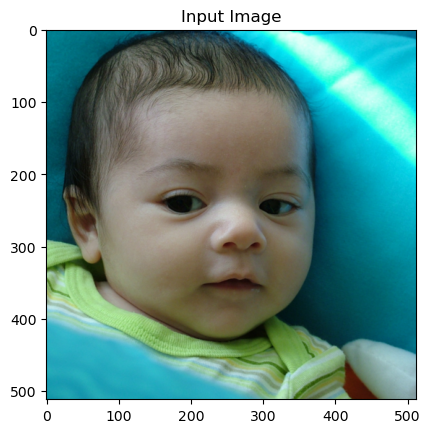

In [12]:
# 使用内容图像的克隆作为输入图像
input_img = content_img.clone()

# 如果使用随机图像作为初始输入，则使用以下代码
# input_img = torch.rand(content_img.data.size(), device=device)

# 显示输入图像
plt.figure()
imshow(input_img, title='Input Image')


In [13]:
def get_input_optimizer(input_img):
    # 设置图片需要求导
  
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """运行风格迁移"""
    print('构建风格迁移模型...')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img)
    
    optimizer = get_input_optimizer(input_img)
    print('梯度下降...')
    run = [0]
    
    while run[0] <= num_steps:

        def closure():
            # 更正更新后图像的值为 0-1
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run[0]))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # 最后一次更新
    input_img.data.clamp_(0, 1)

    return input_img


构建风格迁移模型...


C:\Users\chenl\AppData\Local\Temp\ipykernel_46808\3803601024.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)  # shape [C x 1 x 1]
C:\Users\chenl\AppData\Local\Temp\ipykernel_46808\3803601024.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)    # shape [C x 1 x 1]


梯度下降...
run 50:
Style Loss : 4.957125 Content Loss: 2.755846

run 100:
Style Loss : 2.536992 Content Loss: 2.381114

run 150:
Style Loss : 1.477102 Content Loss: 2.261760

run 200:
Style Loss : 0.865808 Content Loss: 2.169475

run 250:
Style Loss : 0.560268 Content Loss: 2.090877

run 300:
Style Loss : 0.467786 Content Loss: 2.000691



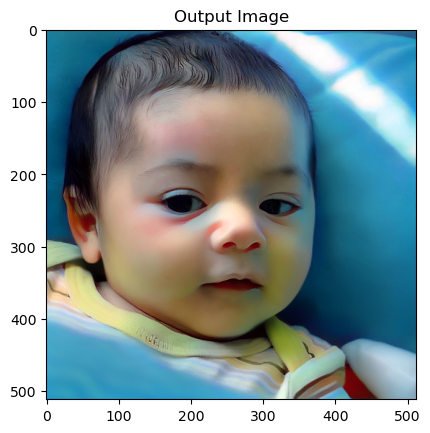

In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, input_img, num_steps=300)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()


构建风格迁移模型...
梯度下降...


C:\Users\chenl\AppData\Local\Temp\ipykernel_46808\3803601024.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)  # shape [C x 1 x 1]
C:\Users\chenl\AppData\Local\Temp\ipykernel_46808\3803601024.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)    # shape [C x 1 x 1]


run 50:
Style Loss : 84.729057 Content Loss: 7.683081

run 100:
Style Loss : 18.291405 Content Loss: 7.579873

run 150:
Style Loss : 10.153889 Content Loss: 6.678820

run 200:
Style Loss : 6.420561 Content Loss: 6.324596

run 250:
Style Loss : 3.883914 Content Loss: 6.102583

run 300:
Style Loss : 2.543807 Content Loss: 5.883367



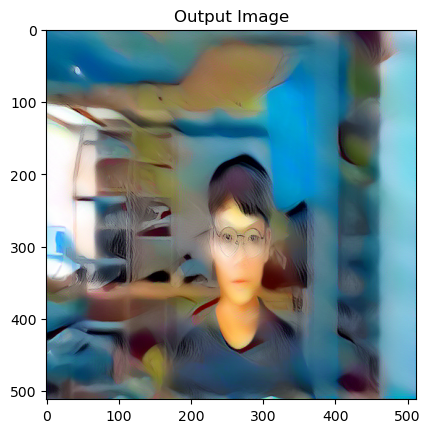

風格化圖片已儲存至 C:\Users\chenl\Desktop\深度學習成果20241104\styled_WIN_20241104_01_28_52_Pro.png


In [18]:
# 設定輸出圖片的大小
imsize = 512 if torch.cuda.is_available() else 128

# 調整 loader，將兩張圖像縮放至一致大小
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # 強制圖片縮放為 imsize x imsize
    transforms.ToTensor()
])

# 重新載入風格圖與內容圖
style_img = image_loader(r"C:\Users\chenl\Desktop\我的深度學習自學\Anime Style Transfer\anime-style-transfer\train\style\00000.png")
content_img = image_loader("C:\\Users\\chenl\\Pictures\\Camera Roll\\WIN_20241104_01_28_52_Pro.jpg")

# 使用內容圖像的克隆作為初始輸入
input_img = content_img.clone()

# 執行風格轉換
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, input_img, num_steps=300)

# 顯示結果
plt.figure()
imshow(output, title='Output Image')

# 儲存風格化圖片
output_image_path = "C:\\Users\\chenl\\Desktop\\深度學習成果20241104\\styled_WIN_20241104_01_28_52_Pro.png"
output_image = transforms.ToPILImage()(output.squeeze(0).cpu())  # 移除批次維度並轉換
output_image.save(output_image_path)
print(f"風格化圖片已儲存至 {output_image_path}")
